# Importing Necessary Libraries and Modules

In [1]:
# Standard library imports
import numpy as np
import cv2
from PIL import Image

# Data processing and manipulation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import torchvision.transforms as transforms

# PyTorch neural network components
from torch.nn import Module, Conv2d, Linear, MaxPool2d, ReLU, LogSoftmax
from torch import flatten

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Loading the dataset

In [2]:
X_train = torch.load("../train/X_train.pt")
y_train = torch.load("../train/y_train.pt")

X_valid = torch.load("../valid/X_valid.pt")
y_valid = torch.load("../valid/y_valid.pt")

X_test = torch.load("../test/X_test.pt")
y_test = torch.load("../test/y_test.pt")

In [3]:
classes_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'NULL', 'a', 'b', 'bye', 'c', 'd', 'e',
 'good', 'good morning', 'hello', 'little bit', 'no', 'pardon', 'please',
 'project', 'whats up', 'yes']

# Creating DataLoaders for training, validation, and testing

In [4]:
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_valid, y_valid)
test_dataset = TensorDataset(X_test, y_test)

In [5]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Checking the shapes of the datasets

In [6]:
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_val:", X_valid.shape)
print("Shape of y_val:", y_valid.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: torch.Size([18240, 3, 32, 32])
Shape of y_train: torch.Size([18240])
Shape of X_val: torch.Size([2280, 3, 32, 32])
Shape of y_val: torch.Size([2280])
Shape of X_test: torch.Size([2281, 3, 32, 32])
Shape of y_test: torch.Size([2281])


# Building the CNN Model

In [7]:
def calculate_h_out_w_out(h_in, w_in, kernel_size, out_channels, stride=(1, 1), padding=(0, 0), dilation=(1, 1)):
    """
    Calculate the output dimensions of a convolutional layer.

    Parameters:
    - h_in (int): Input height.
    - w_in (int): Input width.
    - kernel_size (tuple): Size of the convolution kernel (height, width).
    - out_channels (int): Number of output channels (filters).
    - stride (tuple): Stride of the convolution (height_stride, width_stride). Defaults to (1, 1).
    - padding (tuple): Padding applied to the input (height_padding, width_padding). Defaults to (0, 0).
    - dilation (tuple): Dilation rate for the convolution (height_dilation, width_dilation). Defaults to (1, 1).

    Returns:
    - tuple: (h_out, w_out, out_channels) representing the output height, width, and number of channels.
    """
    # Calculate the output height
    h_out = (h_in + 2 * padding[0] - dilation[0] * (kernel_size[0] - 1) - 1) // stride[0] + 1
    
    # Calculate the output width
    w_out = (w_in + 2 * padding[1] - dilation[1] * (kernel_size[1] - 1) - 1) // stride[1] + 1

    # Ensure output dimensions are integers
    assert isinstance(h_out, int), "Output height is not an integer"
    assert isinstance(w_out, int), "Output width is not an integer"
    
    return (h_out, w_out, out_channels)

In [8]:
# Define the CNN class inheriting from nn.Module
class CNN(Module):
    def __init__(self, in_height, in_width, in_channels, num_classes):
        super(CNN, self).__init__()  # Initialize the parent class

        self.in_features = (in_height, in_width, in_channels)  # Store input feature dimensions

        # First convolutional layer: takes input channels and outputs 16 feature maps
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=(5, 5), padding=(2, 2))
        self.in_features = calculate_h_out_w_out(in_height, in_width, (5, 5), 16, padding=(2, 2))  # Update dimensions after conv1
        self.relu1 = nn.ReLU()  # ReLU activation after the first convolution
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))  # Max pooling to downsample
        self.in_features = calculate_h_out_w_out(self.in_features[0], self.in_features[1], (2, 2), self.in_features[2], stride=(2, 2))  # Update dimensions after maxpool1

        # Second convolutional layer: takes 16 input channels and outputs 32 feature maps
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5, 5))
        self.in_features = calculate_h_out_w_out(self.in_features[0], self.in_features[1], (5, 5), 32)  # Update dimensions after conv2
        self.relu2 = nn.ReLU()  # ReLU activation after the second convolution
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))  # Max pooling to downsample
        self.in_features = calculate_h_out_w_out(self.in_features[0], self.in_features[1], (2, 2), self.in_features[2], stride=(2, 2))  # Update dimensions after maxpool2

        # Third convolutional layer: takes 32 input channels and outputs 64 feature maps
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=(1, 1))
        self.in_features = calculate_h_out_w_out(self.in_features[0], self.in_features[1], (3, 3), 64, padding=(1, 1))  # Update dimensions after conv3
        self.relu3 = nn.ReLU()  # ReLU activation after the third convolution
        self.maxpool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))  # Max pooling to downsample
        self.in_features = calculate_h_out_w_out(self.in_features[0], self.in_features[1], (2, 2), self.in_features[2], stride=(2, 2))  # Update dimensions after maxpool3

        # Fully connected (linear) layer to connect the flattened output from convolutional layers
        self.fc1 = nn.Linear(in_features=self.in_features[0] * self.in_features[1] * self.in_features[2], out_features=2048)
        self.relu_fc1 = nn.ReLU()  # ReLU activation after the first fully connected layer
        self.dropout1 = nn.Dropout(p=0.5)  # Dropout for regularization

        # Second fully connected layer
        self.fc2 = nn.Linear(in_features=2048, out_features=1024)
        self.relu_fc2 = nn.ReLU()  # ReLU activation after the second fully connected layer
        self.dropout2 = nn.Dropout(p=0.5)  # Dropout for regularization

        # Final fully connected layer for classification
        self.fc3 = nn.Linear(in_features=1024, out_features=num_classes)
        self.logSoftmax = nn.LogSoftmax(dim=1)  # LogSoftmax for classification output

    # Define the forward pass of the network
    def forward(self, x):
        x = self.conv1(x)  # Pass input through first convolutional layer
        x = self.relu1(x)  # Apply ReLU activation
        x = self.maxpool1(x)  # Apply max pooling

        x = self.conv2(x)  # Pass through second convolutional layer
        x = self.relu2(x)  # Apply ReLU activation
        x = self.maxpool2(x)  # Apply max pooling

        x = self.conv3(x)  # Pass through third convolutional layer
        x = self.relu3(x)  # Apply ReLU activation
        x = self.maxpool3(x)  # Apply max pooling

        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layers

        x = self.fc1(x)  # Pass through first fully connected layer
        x = self.relu_fc1(x)  # Apply ReLU activation
        x = self.dropout1(x)  # Apply dropout for regularization

        x = self.fc2(x)  # Pass through second fully connected layer
        x = self.relu_fc2(x)  # Apply ReLU activation
        x = self.dropout2(x)  # Apply dropout for regularization

        x = self.fc3(x)  # Pass through the final fully connected layer
        x = self.logSoftmax(x)  # Apply LogSoftmax activation for output

        return x  # Return the final output


# Model Training

In [9]:
def get_device():
  return torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
def count_parameters(model):
  total_params = sum(p.numel() for p in model.parameters())

  # Iterate through the layers and print their details
  for name, layer in model.named_children():
        num_params = sum(p.numel() for p in layer.parameters())
        print(f"Layer: {name}, Parameters: {num_params}")

  return total_params

In [11]:
def train(model, criterion, optimizer, n_epochs, train_loader, valid_loader, multiclass=False):
    # Initialize lists for traininf and validation loss and accuracy for each epoch
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    
    # Get the appropriate device
    device = get_device()

    # Iterate over each epoch
    for epoch in range(n_epochs):
        # >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> TRAINING <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

        model.train()                                # Set the model to training mode
        
        epoch_train_batches_loss = 0.0               # Loss for the current epoch
        epoch_train_correct_predictions = 0          # Number of correct predictions
        epoch_train_total_predictions = 0            # Total number of instances processed

        # Iterate over batches in the training data loader
        for inputs, labels in train_loader:
            # Move inputs and labels to the device
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Gradients from the previous batch are zeroed out to prevent accumulation
            optimizer.zero_grad()
            
            # Compute the model output
            outputs = model(inputs)
            
            # Compute the loss based on the criterion passed 
            loss = criterion(outputs.squeeze(), labels)
            
            # Compute the gradients
            loss.backward()
            
            # Update the model parameters using the optimizer
            optimizer.step()

            # Accumulate the loss for the current batch
            epoch_train_batches_loss += loss.item()

            # Predict
            if multiclass:
                predicted = torch.argmax(outputs, dim=1)
            else:
                predicted = (outputs > 0.5).float()
            
            # Update the number of correct predictions
            epoch_train_correct_predictions += (predicted.squeeze() == labels).sum().item()
            
            # Update the total number of instances processed
            epoch_train_total_predictions += labels.size(0)

        # Calculate the average loss for the training epoch
        epoch_train_loss = epoch_train_batches_loss / len(train_loader)
        
        # Calculate the accuracy for the training epoch
        epoch_train_accuracy = epoch_train_correct_predictions / epoch_train_total_predictions
        
        # Store the loss and accuracy for training
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)

        # >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> VALIDATION <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

        model.eval()                               # Set the model to evaluation mode
        
        epoch_valid_loss = 0.0                       # Loss for the current validation epoch
        epoch_valid_correct_predictions = 0          # Number of correct predictions
        epoch_valid_total_predictions = 0            # Total number of instances processed
        
        with torch.no_grad():  # Disable gradient computation for validation
            for inputs, labels in valid_loader:
                # Move inputs and labels to the device
                inputs, labels = inputs.to(device), labels.to(device)

                # Compute the model output
                outputs = model(inputs)
                
                # Compute the loss based on the criterion passed 
                loss = criterion(outputs.squeeze(), labels)
                
                # Accumulate the loss for the current batch
                epoch_valid_loss += loss.item()

                # Predict
                if multiclass:
                    predicted = torch.argmax(outputs, dim=1)
                else:
                    predicted = (outputs > 0.5).float()
                
                # Update the number of correct predictions
                epoch_valid_correct_predictions += (predicted.squeeze() == labels).sum().item()
                
                # Update the total number of instances processed
                epoch_valid_total_predictions += labels.size(0)
        
        # Calculate the average loss and accuracy for the validation epoch
        epoch_valid_loss /= len(valid_loader)
        epoch_valid_accuracy = epoch_valid_correct_predictions / epoch_valid_total_predictions

        valid_losses.append(epoch_valid_loss)
        valid_accuracies.append(epoch_valid_accuracy)
        
        print(f"Epoch [{epoch + 1}/{n_epochs}], Train Loss: {epoch_train_loss:.4f}, "
              f"Train Accuracy: {epoch_train_accuracy:.4f}, "
              f"Val Loss: {epoch_valid_loss:.4f}, Val Accuracy: {epoch_valid_accuracy:.4f}")

    # Return the losses and accuracies over all epochs
    return train_losses, train_accuracies, valid_losses, valid_accuracies

In [12]:
image_height = X_train.shape[2]
image_width = X_train.shape[2]
n_channels = X_train.shape[1]
n_classes = len(np.unique(y_train))

In [13]:
model = CNN(in_height=image_height, in_width=image_width, in_channels=n_channels, num_classes=n_classes)
model

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=576, out_features=2048, bias=True)
  (relu_fc1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=2048, out_features=1024, bias=True)
  (relu_fc2): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=1024, out_features=27, bias=True)
  (logSoftmax): LogSoftmax(dim=1)
)

In [14]:
count_parameters(model)

Layer: conv1, Parameters: 1216
Layer: relu1, Parameters: 0
Layer: maxpool1, Parameters: 0
Layer: conv2, Parameters: 12832
Layer: relu2, Parameters: 0
Layer: maxpool2, Parameters: 0
Layer: conv3, Parameters: 18496
Layer: relu3, Parameters: 0
Layer: maxpool3, Parameters: 0
Layer: fc1, Parameters: 1181696
Layer: relu_fc1, Parameters: 0
Layer: dropout1, Parameters: 0
Layer: fc2, Parameters: 2098176
Layer: relu_fc2, Parameters: 0
Layer: dropout2, Parameters: 0
Layer: fc3, Parameters: 27675
Layer: logSoftmax, Parameters: 0


3340091

In [15]:
n_epochs = 30
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [16]:
train_losses, train_accuracies, valid_losses, valid_accuracies = train(model, criterion, optimizer, n_epochs, train_loader, val_loader, True)


Epoch [1/30], Train Loss: 3.1195, Train Accuracy: 0.0787, Val Loss: 2.4483, Val Accuracy: 0.2228
Epoch [2/30], Train Loss: 1.9442, Train Accuracy: 0.3726, Val Loss: 1.4307, Val Accuracy: 0.5237
Epoch [3/30], Train Loss: 1.3038, Train Accuracy: 0.5672, Val Loss: 1.1223, Val Accuracy: 0.6285
Epoch [4/30], Train Loss: 0.9980, Train Accuracy: 0.6709, Val Loss: 0.8260, Val Accuracy: 0.7333
Epoch [5/30], Train Loss: 0.7987, Train Accuracy: 0.7357, Val Loss: 0.7719, Val Accuracy: 0.7588
Epoch [6/30], Train Loss: 0.6639, Train Accuracy: 0.7804, Val Loss: 0.7165, Val Accuracy: 0.7772
Epoch [7/30], Train Loss: 0.5631, Train Accuracy: 0.8143, Val Loss: 0.6655, Val Accuracy: 0.7974
Epoch [8/30], Train Loss: 0.4771, Train Accuracy: 0.8440, Val Loss: 0.6228, Val Accuracy: 0.8132
Epoch [9/30], Train Loss: 0.4230, Train Accuracy: 0.8594, Val Loss: 0.5714, Val Accuracy: 0.8294
Epoch [10/30], Train Loss: 0.3695, Train Accuracy: 0.8763, Val Loss: 0.6232, Val Accuracy: 0.8114
Epoch [11/30], Train Loss: 0.

# Training Metrics Visualization

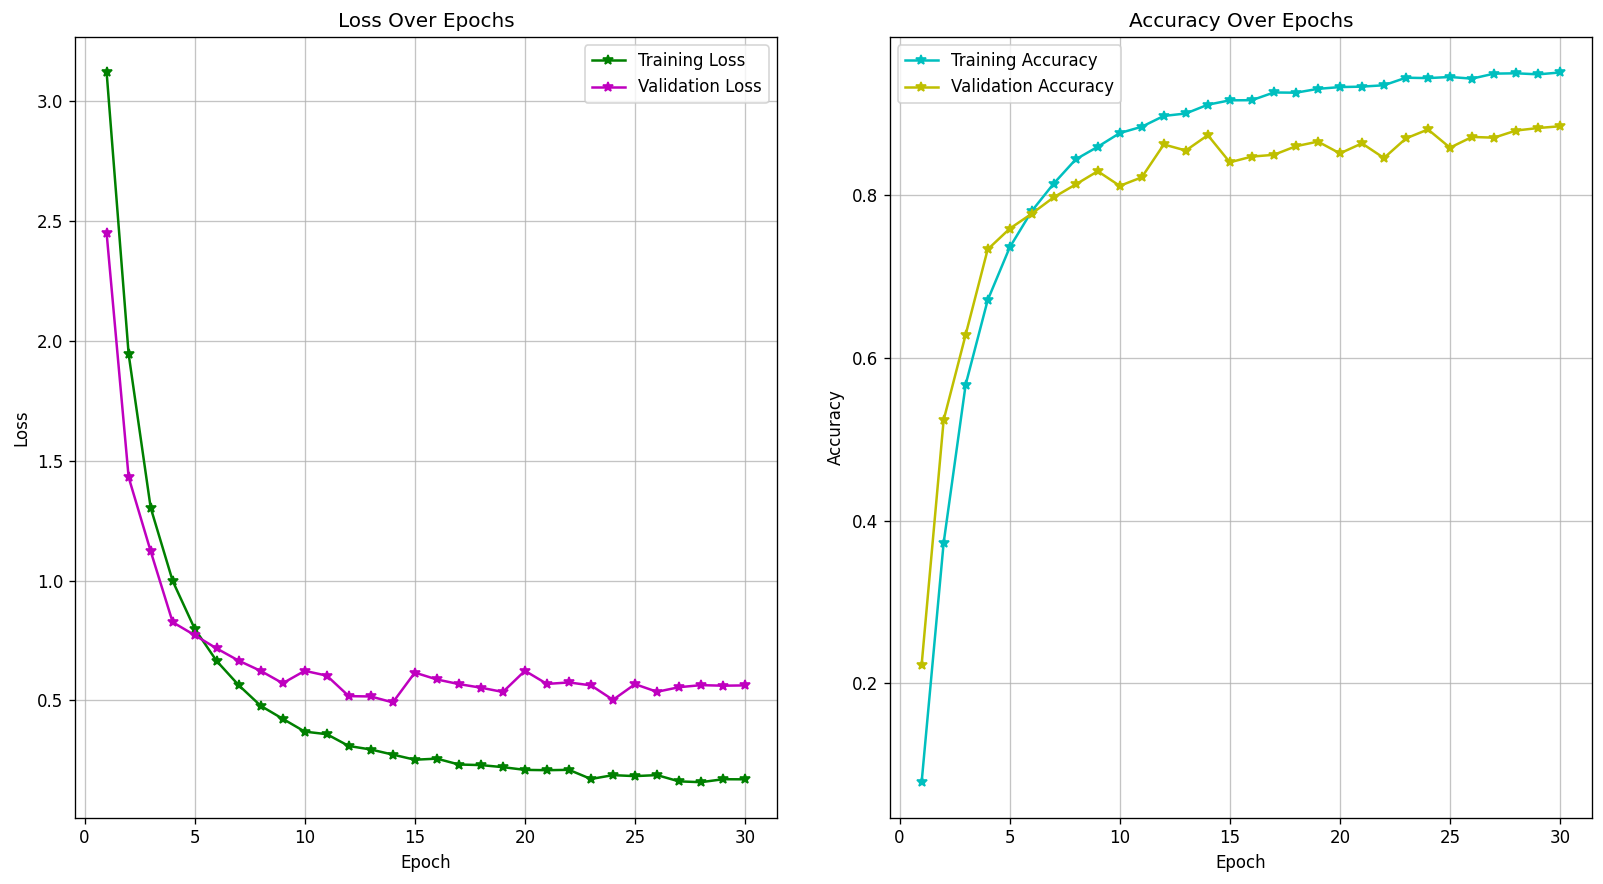

In [17]:
def visualize_training_metrics(train_losses, train_accuracies, valid_losses, valid_accuracies):
    fig_size = (14, 8)
    plot_resolution = 120
    grid_alpha = 0.75

    epoch_numbers = list(range(1, len(train_losses) + 1))

    plt.figure(figsize=fig_size, dpi=plot_resolution)
    
    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epoch_numbers, train_losses, 'g*-', label='Training Loss')
    plt.plot(epoch_numbers, valid_losses, 'm*-', label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')
    plt.grid(True, alpha=grid_alpha)
    
    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epoch_numbers, train_accuracies, 'c*-', label='Training Accuracy')
    plt.plot(epoch_numbers, valid_accuracies, 'y*-', label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.grid(True, alpha=grid_alpha)
    
    plt.tight_layout(pad=3.0)
    plt.show()

# Pozivanje funkcije sa podacima
visualize_training_metrics(train_losses, train_accuracies, valid_losses, valid_accuracies)


# Evaluation Process

In [18]:
def evaluate(model, criterion, loader, multiclass=False):
    # Set the model to evaluation mode
    model.eval()
    
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    
    predicted_labels, true_labels = [], []
    
    # Get the device
    device = get_device()

    # Disable gradient computation during evaluation
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Get model predictions
            outputs = model(inputs)
            
            # Compute loss
            total_loss += criterion(outputs.squeeze(), labels).item()

            # Predict class labels
            if multiclass:
                predicted = torch.argmax(outputs, dim=1)
            else:
                predicted = (outputs > 0.5).float()
                
            # Append predictions and true labels for metric computation
            predicted_labels.extend(predicted.squeeze().tolist())
            true_labels.extend(labels.tolist())

            # Update total samples and correct predictions count
            total_samples += labels.size(0)
            total_correct += (predicted.squeeze() == labels).sum().item()

    # Compute evaluation metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')
    
    # Print evaluation results
    print(f'Model evaluation on: {loader}')
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1_score:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(10, 6))
    cm = confusion_matrix(true_labels, predicted_labels)
    sns.heatmap(cm, annot=True, fmt='d',  xticklabels=classes_names,  yticklabels=classes_names)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.show()

    # Average loss over all batches
    avg_loss = total_loss / len(loader)
    accuracy = total_correct / total_samples

    return avg_loss, accuracy

Model evaluation on: <torch.utils.data.dataloader.DataLoader object at 0x00000216829C8080>
Accuracy: 0.8846
Precision: 0.8889
Recall: 0.8846
F1 Score: 0.8848


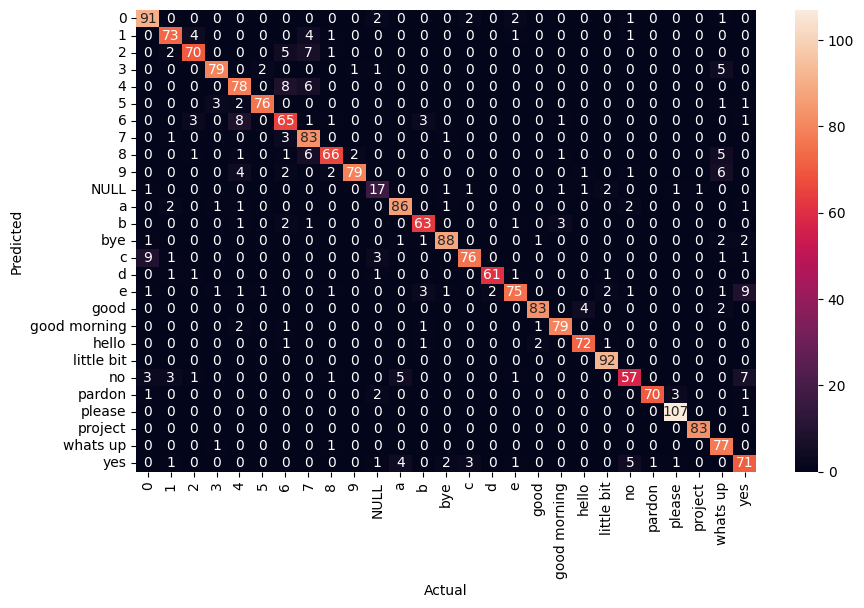

Model evaluation on: <torch.utils.data.dataloader.DataLoader object at 0x0000021682ACCB60>
Accuracy: 0.8878
Precision: 0.8934
Recall: 0.8878
F1 Score: 0.8878


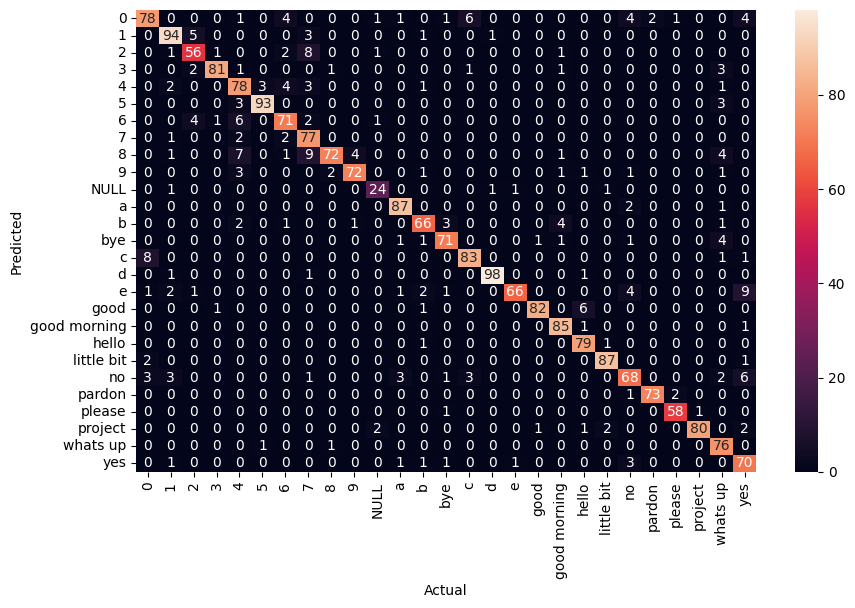

In [19]:
# Evaluate on validation and test sets
print("="*150)
valid_loss, val_accuracy = evaluate(model, criterion, val_loader, multiclass=True)
print("="*150)
test_loss, test_accuracy = evaluate(model, criterion, test_loader, multiclass=True)

In [20]:
torch.save(model.state_dict(), 'model2.pth')